In [1]:
# Generic libraries
import os
import h5py
import time
from functools import partial

# Scientific libraries
import numpy as np
from scipy import constants, special
from scipy.stats import binned_statistic_2d
import scipy.ndimage

# Data analysis
import pandas as pd
from sklearn.decomposition import PCA, KernelPCA

# Functions that I have written
from basis_funcs import *

# Plotting libraries
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style("ticks")

In [14]:
wd1 = "/Users/jan/Documents/THOR"
wd2 = "/home/jan/Desktop/THOR_picketfence"
curr = wd1
dfile_hd189   = curr + "/picket_fence_HD189b/hd189b_chemoff_nhs_2/regrid_height_HD189733b_50.h5"
dfile_hd209   = curr + "/picket_fence_HD209b/hd209b_chemoff_nhs_3/regrid_height_HD209458b_40.h5"
dfile_wasp31  = curr + "/picket_fence_WASP-31b/wasp31b_chemoff_nhs/regrid_height_WASP-31b_20.h5"
dfile_wasp17  = curr + "/picket_fence_WASP-17b/wasp17b_chemoff_nhs/regrid_height_WASP-17b_16.h5"
dfile_wasp74  = curr + "/picket_fence_WASP-74b/wasp74b_chemoff_nhs/regrid_height_WASP-74b_40.h5"
dfile_wasp19  = curr + "/picket_fence_WASP-19b/wasp19b_chemoff_nhs/regrid_height_WASP-19b_20.h5"
dfile_wasp121 = curr + "/picket_fence_WASP-121b/wasp121b_chemoff_nhs_2/regrid_height_WASP-121b_40.h5"

data = h5py.File(dfile_wasp74, 'r')

pfile_hd189 = curr + "/picket_fence_HD189b/hd189b_chemoff_nhs_2/pgrid_40_50_1/regrid_HD189733b_50.h5"
pfile_hd209 = curr + "/picket_fence_HD209b/hd209b_chemoff_nhs_3/pgrid_0_50_1/regrid_HD209458b_50.h5"
pfile_wasp31 =  curr + "/picket_fence_WASP-31b/wasp31b_chemoff_nhs/pgrid_0_20_1/regrid_WASP-31b_20.h5"
pfile_wasp17 =  curr + "/picket_fence_WASP-17b/wasp17b_chemoff_nhs/pgrid_0_16_1/regrid_WASP-17b_16.h5"
pfile_wasp74 =  curr + "/picket_fence_WASP-74b/wasp74b_chemoff_nhs/pgrid_0_40_1/regrid_WASP-74b_40.h5"
pfile_wasp19 =  curr + "/picket_fence_WASP-19b/wasp19b_chemoff_nhs/pgrid_0_20_1/regrid_WASP-19b_20.h5"
pfile_wasp121 = curr + "/picket_fence_WASP-121b/wasp121b_chemoff_nhs_2/pgrid_0_40_1/regrid_WASP-121b_40.h5"

pdata = h5py.File(pfile_wasp74, 'r')

In [15]:
data.keys()

<KeysViewHDF5 ['Altitude', 'AngMomz', 'Cp', 'DGf_net', 'DGqheat', 'Entropy', 'Etotal', 'Latitude', 'Longitude', 'PV', 'Pressure_mean', 'RVu', 'RVv', 'RVw', 'Rd', 'Rho', 'Rho_mean', 'Temperature', 'Temperature_mean', 'U', 'U_mean', 'V', 'V_mean', 'W', 'W_mean', 'flw_dn', 'flw_up', 'fsw_dn', 'insol', 'qheat', 'tau_lw', 'tau_sw']>

In [16]:
def specs_parser(files, params):
    '''
    Parses given namelist files and scrapes relevant run info from them. (Currently only configured for THOR runs)
    I could probably just duplicate the file and change its extension to .py and import it...
   
    Parameters
    ----------
    files: list
        List of runfile parameter files 
    
    Returns
    -------
    pspecs: dict
         A nested dictionary containing exoplanet specs 
    '''
    # Define a conversion list between conventions
    conversion = {"simulation_ID":"Name", "Tstar":"T_star", "radius":"R", "planet_star_dist":"a", "radius_star":"R_star", "Cp":"c_P", "gravitation":"g_P"}
    pspecs = {}
    for curdir in files:
        temp_dict = {}
        # Parse files and fill in dictionary
        file = open(curdir, 'r')
        content = file.read()
        lines = content.split("\n") #split it into lines
        for line in lines:
            if (not line.startswith("#") and line.strip() and line.split(" = ")[0] in params):
                temp = line.split(" = ")
                # This method with try and except only works for the current setup. I am too lazy to code it better for now...
                try:
                    temp_dict[conversion[temp[0]]] = float(temp[1])
                except:
                    name = temp[1]
        pspecs[name] = temp_dict
        print(name, temp_dict)
    
    return pspecs

In [17]:
def v_los(vs, theta_v, phi_v, omega, R, z, lats, lons):
    '''
    Calculates the line-of-sight velocity for a given set of viewing angles and GCM outputs.
    
    Parameters
    ----------
    vs: ~numpy.array
        Array filled with [u, v, w] 
    theta_v : float
        Viewing latitude
    phi_v : float
        Viewing longitude
    omega: float
        Rotation rate of the planet
    R: float
        Lower boundary of the planetary radius
    z: float
        Altitude of the velocity field 
    lats: ~numpy.array
        Latitudes from the simulation
    lons: ~numpy.array
        Longitudes from the simulation
    
    Returns
    -------
    vlos: ~numpy.array
        Line-of-sight velocities
        
    '''
    # I am sure I can write this without the for-loops
    vlos = np.zeros((lats.shape[0], lons.shape[0]))
    for t,theta in enumerate(lats):
        for p,phi in enumerate(lons):
            t1 = vs[0,t,p] * np.sin(theta_v) * np.sin(phi - phi_v)
            t2 = (vs[1,t,p] * np.cos(theta) - vs[2,t,p] * np.sin(theta)) * np.sin(theta_v) * np.cos(phi - phi_v)
            t3 = (vs[1,t,p] * np.sin(theta) + vs[2,t,p] * np.cos(theta)) * np.cos(theta_v)
            t4 = omega * (R * theta  + z) * np.sin(theta) * np.sin(theta_v) * np.sin(phi - phi_v)
            vlos[t][p] = t1 + t2 - t3 + t4 
    return vlos

In [88]:
def v_los_alt(vs, theta_v, phi_v, omega, R, z, lats, lons):
    '''
    Calculates the line-of-sight velocity for a given set of viewing angles and GCM outputs.
    
    Parameters
    ----------
    vs: ~numpy.array
        Array filled with [u, v, w] 
    theta_v : float
        Viewing latitude
    phi_v : float
        Viewing longitude
    omega: float
        Rotation rate of the planet
    R: float
        Lower boundary of the planetary radius
    z: float
        Altitude of the velocity field 
    lats: ~numpy.array
        Latitudes from the simulation
    lons: ~numpy.array
        Longitudes from the simulation
    
    Returns
    -------
    vlos: ~numpy.array
        Line-of-sight velocities
        
    '''
    t1   = vs[0,...] * np.sin(theta_v) * np.sin(lons - phi_v)
    t2   = (vs[1,...].T * np.cos(lats) - vs[2,...].T * np.sin(lats)).T * np.sin(theta_v) * np.cos(lons - phi_v)
    t3   = (vs[1,...].T * np.sin(lats) + vs[2,...].T * np.cos(lats)).T * np.cos(theta_v)
    t4   = (omega * (R * lats + z) * np.sin(lats) * np.sin(theta_v))[:, np.newaxis] * np.sin(lons - phi_v)
    vlos = t1 + t2 - t3 + t4 
    return vlos

In [84]:
# Make a line-of-sight velocity map
## I should start with the easy case here 
    # Then I could vary the viewing angles to simulate a transit
    # Finally I should perform a fit over different pressure levels
    # With this approach I'll have 100+ free parameters so it is a collection of fits?
    # Can we learn something from a single pressure level?
    # Can I write an objective function which penalizes fits that don't have the same "statistical properties" as the ground truth?
## Try the fitting procedure on this new scalar map
# The fit won't function the way I am thinking about it right now or rather it won't be useful
# I need to find a way of defining the part of the atmosphere that will be invisible to transmission 
# Wrap your head around, shooting a ray of light from the observer side, whatever passes through without hitting the planet is important
# Then I need to convert these observer-side angles into spherical coordinates from the rest frame of the planet

$$ v_{LOS} = u \sin(\theta_{v}) \sin(\phi − \phi_{v}) + [v \cos(\theta) − w sin(\theta )] sin(\theta_{v}) cos(\phi  − \phi_{v}) − [v sin(\theta ) + w cos(\theta )] cos(\theta_{v}) + \Omega (R \theta  + z) sin(\theta ) sin(\theta_{v}) sin(\phi  − \phi_{v})$$

In [100]:
%%time
# Get the height level corresponding to a certain pressure
vcoord = pdata["Pressure"][()] / 1e5 # Convert the pressure values in Pa to bar
Plev = 0.1 # [bar]
p_mask = np.argwhere(vcoord == np.min(vcoord[vcoord >= Plev]))
vlev = p_mask[0][0]

vlev = -1

# Truncating the the sphere at the poles a bit to circumvent singularities
lower_bound = 0.3 * 180/np.pi - 90
upper_bound = (np.pi - 0.3) * 180/np.pi - 90

lat_mask = np.argwhere((pdata["Latitude"][()] >= lower_bound) & (pdata["Latitude"][()] <= upper_bound))

# Grid angles 
lon = pdata["Longitude"][()]
lon_rad = lon * np.pi/180
lat = pdata["Latitude"][()][lat_mask].flatten()
lat_rad = lat * np.pi/180 + np.pi/2
print(f"Truncated latitudes: {lat.shape}")

# Ground truth
v_phi, v_theta = np.squeeze((pdata["U"][:,:,vlev])[lat_mask,:],axis=1), np.squeeze((pdata["V"][:,:,vlev])[lat_mask,:],axis=1)
v_r =  np.squeeze((pdata["W"][:,:,vlev])[lat_mask,:],axis=1)
temp = pdata["Temperature_mean"][:,:,vlev]
alt  = data["Altitude"][vlev]
R     = 1.12e8  # [m] Hard-coded for now, I'll adapt specs_parser for this purpose 
omega = 3.40e-5 # [rad * s^-1]
z    = alt
vs   = np.array((v_phi, v_theta, v_r))
factor = 2*np.pi/360
phi_v, theta_v = 180. * factor, 90. * factor # Choose viewing angles
res_vs = v_los_alt(vs, theta_v, phi_v, omega, R, z, lat_rad, lon_rad) 

Truncated latitudes: (72,)
(72, 180)
CPU times: user 31.5 ms, sys: 16.2 ms, total: 47.7 ms
Wall time: 108 ms


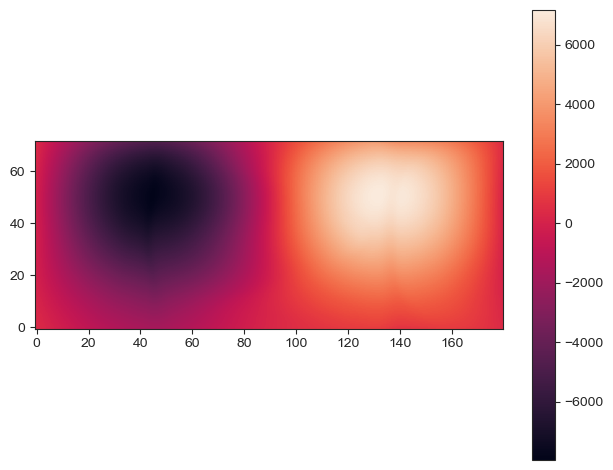

In [101]:
plt.figure()
plt.imshow(res_vs, origin='lower')
plt.colorbar()
plt.tight_layout()
# plt.savefig("los_velocity.png", dpi=500)

(72, 180)


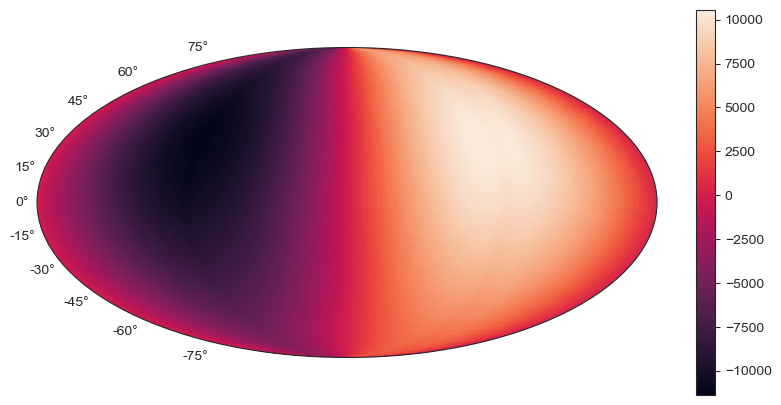

In [27]:
lon = np.linspace(-np.pi, np.pi,res_vs.shape[1])
lat = np.linspace(-np.pi/2., np.pi/2.,res_vs.shape[0])
Lon,Lat = np.meshgrid(lon,lat,)

plt.subplots(subplot_kw={'projection': "mollweide"}, figsize=(10,5))
plt.pcolormesh(Lon,Lat,res_vs,shading='auto')
plt.colorbar()
print(res_vs.shape)
# plt.savefig("los_velocity.png", dpi=500)

In [ ]:
np.nonzero(res_vs)

In [ ]:
writer = imageio.get_writer("hd189b_Tu_anim.mp4",fps=7)
 
# compute fig size so that it gets rounded to closest multiple of video macro_block_size
FIGSIZE_x = 16
FIGSIZE_y = 8
dpi = 192

block_size = 16
fs_x = (math.ceil((FIGSIZE_x*dpi)/float(block_size))*block_size)/dpi
fs_y = (math.ceil((FIGSIZE_y*dpi)/float(block_size))*block_size)/dpi

fig = plt.Figure(figsize=(fs_x, fs_y), dpi=dpi)
#ax1 = fig.subplots(2, 1)

clevs = np.linspace(np.min(T[:,:,vlev,:]),np.max(T[:,:,vlev,:]),30)
clevs2 = np.linspace(np.min(U[:,:,vlev,:]),np.max(U[:,:,vlev,:]),30)

for i in range(0,T.shape[3]):
    fig.clear() 
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    fig.subplots_adjust(left=0.05,right=0.98,wspace=0.1)
    fig.suptitle('Time = %#.1f days'%time[i],fontsize=20)

    # ax.set_xlabel('Longitude (deg)')
    # ax.set_ylabel('Latitude (deg)')

    # pressure perturbation on lowest level

    c = ax1.contourf(out.rg.Longitude,out.rg.Latitude,T[:,:,vlev,i],levels=clevs)
    # T_new = np.hstack([T[:,100:,level,i],T[:,:100,level,i]])
    #map = Basemap(projection='ortho',lat_0=25,lon_0=135,ax=ax1)
    #lons, lats = np.meshgrid(out.rg.Longitude,out.rg.Latitude)
    # x, y = map(lons,lats)
    # c = map.contourf(x,y,T_new,levels=clevs,cmap='jet')
    clb = plt.colorbar(c,ax=ax1)
    ax1.set_title('Temperature (K)',fontsize=16)
    ax1.set_xlabel('Longitude (deg)')
    ax1.set_ylabel('Latitude (deg)')

    c = ax2.contourf(out.rg.Longitude,out.rg.Latitude,U[:,:,vlev,i],levels=clevs2,cmap='viridis')
    clb = plt.colorbar(c,ax=ax2)
    ax2.set_title('Eastward wind speed (m/s)',fontsize=16)
    ax2.set_xlabel('Longitude (deg)')
    ax2.set_ylabel('Latitude (deg)')

    canvas = FigureCanvasAgg(fig)
    canvas.draw()
    buf = canvas.buffer_rgba()
    X = np.asarray(buf)
    writer.append_data(X)

writer.close()

In [ ]:
 def transit_depth(self):
    '''
    Function to calculate the transit depth as described in Heng & Kitzmann (2017). Inspired by the implementation of Fischer et.al.(2018)
    
    Parameters:
    -----------
    T
    kappa_cloud
    r_c
    R0
    P0
    mass_fraction
    molecular_mass
    
    Returns:
    --------
    
    '''
    
    my_temp = self.parameter_dict["T"]
    if self.parameter_dict["log_kappa_cloud"] == "Off":
        if self.parameter_dict["log_kappa_0"] == "Off":
            kappa_cloud = 0     # cloudfree case
        else:
            kappa_0 = 10 ** self.parameter_dict["log_kappa_0"]
            r_c = 10 ** self.parameter_dict["log_r_c"]
            x = 2 * np.pi * r_c * self.x_full
            kappa_cloud = kappa_0 / (self.parameter_dict["Q0"] * (x ** -(self.parameter_dict["a"])) + x ** 0.2)
    else:
        kappa_cloud = 10**self.parameter_dict["log_kappa_cloud"]

    R0 = self.parameter_dict["R0"]*rjup
    P0 = (10**self.parameter_dict["log_P0"])*1e6   # convert to cgs

    mass_fraction = []
    molecular_mass = []
    kappa = []
    for molecule in molecules:
        abundance_name = molecular_abundance_dict[molecule]
        mass_fraction.append([10**self.parameter_dict[abundance_name]])
        molecular_mass.append([molecular_mass_dict[molecule]])
        opacity = self.molecular_opacity(my_temp, self.opacity_grid[molecule])
        kappa.append([opacity])

    mass_fraction = np.array(mass_fraction)
    molecular_mass = np.array(molecular_mass)
    kappa = np.array(kappa)
    kappa = kappa.reshape(kappa.shape[0],kappa.shape[2])

    xh2 = (1 - np.sum(mass_fraction))/1.1   # calculate abundance of H2
    if 'm' not in globals():                # set mean molecular weight if not given in input
        m = 2.4*xh2*amu + np.sum(mass_fraction*molecular_mass)

    pressure_cia = 10**self.parameter_dict["log_p_cia"]

    if my_temp < 200:       # add in cia opacities
        kappa_cia = 0
    else:
        sigma_h2he = self.cia_cross_section(my_temp, self.opacity_grid['cia_h2he'])
        sigma_h2h2 = self.cia_cross_section(my_temp, self.opacity_grid['cia_h2h2'])
        ntot = pressure_cia*1e6/kboltz/my_temp
        kappa_cia = xh2 * ntot * (xh2 * sigma_h2h2 + 0.1*xh2 * sigma_h2he) / m

    sigma_rayleigh = 8.4909e-45*(self.x_full**4)        # rayleigh scattering cross-section from Vardya (1962)
    kappa_rayleigh = xh2*sigma_rayleigh/m

    kappa_total_molecules = np.sum(mass_fraction*molecular_mass*kappa, axis=0) /m  # sum opacity contributions from molecules
    kappa_total = kappa_total_molecules + kappa_cloud + kappa_cia + kappa_rayleigh      # add in cloud, rayleigh and cia opacities

    h = kboltz*my_temp/m/g
    term1 = P0*kappa_total/g
    term2 = np.sqrt(2.0*np.pi*R0/h)
    r = R0 + h * (gamma + np.log(term1 * term2))

    result = 100.0 * (r / rstar) ** 2  # return percentage transit depth
    return result